In [2]:
# %load ./imports.py
# %load /Users/bartev/dev/github-bv/sporty/notebooks/imports.py

## Where am I
!echo $VIRTUAL_ENV

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# magics
%load_ext blackcellmagic
# start cell with `%%black` to format using `black`

%load_ext autoreload
# start cell with `%autoreload` to reload module
# https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html

# reload all modules when running
%autoreload 2

# imports

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

from importlib import reload
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# https://plotnine.readthedocs.io/en/stable/

import plotnine as p9
from plotnine import ggplot, aes, facet_wrap

from src.utils import lower_case_col_names, drop_suffix
import src.data.load_data as ld
from src.data.load_data import get_nba_game_team_points, load_nba, load_nba_games_dataset


/Users/bartev/.venvs/sport


# Import updated NBA Game data

In [41]:
nba_games = load_nba_games_dataset()
nba_games.head()

/Users/bartev/dev/github-bv/sporty/src/utils.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
/Users/bartev/dev/github-bv/sporty/src/utils.py:13: FutureWarning: The default value of regex will change from True to False in a future version.


,game_date,game_id,season,home_team_wins,team_id,pts,fg_pct,ft_pct,fg3_pct,ast,reb,ha,wl,nickname,city,fgm,fga,fg3m,fg3a,ftm,fta
811,2018-09-28,11800002,2018,1,1610612738,97.000,0.346,0.727,0.191,12.000,56.000,away,L,Celtics,Boston,36.000,104.000,9.000,47.000,16.000,22.000
1671,2018-09-28,11800002,2018,1,1610612766,104.000,0.382,0.641,0.306,17.000,65.000,home,W,Hornets,Charlotte,34.000,89.000,11.000,36.000,25.000,39.000
164,2018-09-29,11800003,2018,1,1610612761,122.000,0.415,0.824,0.343,15.000,45.000,home,W,Raptors,Toronto,34.000,82.000,12.000,35.000,42.000,51.000
422,2018-09-29,11800003,2018,1,1610612757,104.000,0.420,0.720,0.387,25.000,46.000,away,L,Trail Blazers,Portland,37.000,88.000,12.000,31.000,18.000,25.000
55,2018-09-29,11800005,2018,0,1610612744,110.000,0.473,0.769,0.353,33.000,48.000,home,L,Warriors,Golden State,44.000,93.000,12.000,34.000,10.000,13.000


# Central tendency vs variation

Compare the success rates of 2 point FG and 3 pt FG to demonstrate the difference between central tendency and variaion

## Calculate the summary statistics for the percentages of 2 pt FG and 3 pt FG

In [4]:
nba_games['fg_pct'].describe()

count   2,756.000
mean        0.460
std         0.054
min         0.278
25%         0.422
50%         0.459
75%         0.494
max         0.649
Name: fg_pct, dtype: float64

In [5]:
nba_games['fg3_pct'].describe()

count   2,756.000
mean        0.354
std         0.087
min         0.100
25%         0.296
50%         0.351
75%         0.409
max         0.842
Name: fg3_pct, dtype: float64

## Compare the distribution of 2pt and 3pt FG percentage using a histogram

### Side by side

array([[<AxesSubplot:title={'center':'fg_pct'}>,
        <AxesSubplot:title={'center':'fg3_pct'}>]], dtype=object)

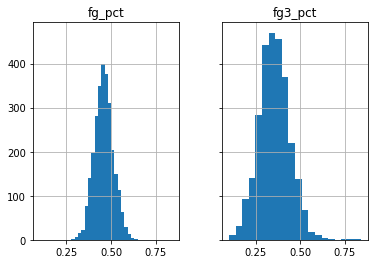

In [12]:
nba_games.hist(column=['fg_pct', 'fg3_pct'], bins=20, sharex=True, sharey=True, grid=True)

### Plot 2 histograms in the same graph in different colors

* Use `plot.hist` instead of `hist`
* add title and axis labels using `plt.title` and `plt.xlabel`, `plt.ylabel`

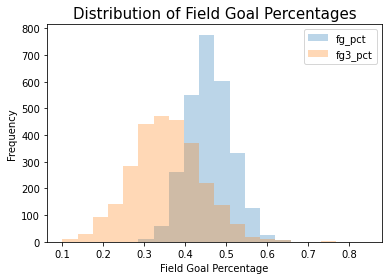

In [10]:
nba_games[['fg_pct', 'fg3_pct']].plot.hist(alpha=0.3, bins=20)
plt.xlabel('Field Goal Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Field Goal Percentages', fontsize=15)
plt.savefig('fg_pct_distrib.png')

## Make graphs grouped by criteria

array([<AxesSubplot:title={'center':'L'}>,
       <AxesSubplot:title={'center':'W'}>], dtype=object)

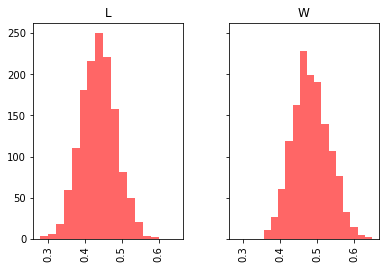

In [22]:
nba_games.hist(by='wl', column='fg_pct', color='red', bins=15, sharex=True, sharey=True, alpha=0.6, grid=True)

# Create time series graph

First, change the data type of 'game_date' to `datetime`

In [25]:
nba_games.dtypes

game_date          object
game_id            object
season              int64
home_team_wins      int64
team_id            object
pts               float64
fg_pct            float64
ft_pct            float64
fg3_pct           float64
ast               float64
reb               float64
ha                 object
wl                 object
nickname           object
city               object
fgm               float64
fga               float64
fg3m              float64
fg3a              float64
ftm               float64
fta               float64
dtype: object

In [43]:
nba_games_d = nba_games.assign(game_date = lambda x: pd.to_datetime(x['game_date']))
nba_games_d.head()

,game_date,game_id,season,home_team_wins,team_id,pts,fg_pct,ft_pct,fg3_pct,ast,reb,ha,wl,nickname,city,fgm,fga,fg3m,fg3a,ftm,fta
811,2018-09-28,11800002,2018,1,1610612738,97.000,0.346,0.727,0.191,12.000,56.000,away,L,Celtics,Boston,36.000,104.000,9.000,47.000,16.000,22.000
1671,2018-09-28,11800002,2018,1,1610612766,104.000,0.382,0.641,0.306,17.000,65.000,home,W,Hornets,Charlotte,34.000,89.000,11.000,36.000,25.000,39.000
164,2018-09-29,11800003,2018,1,1610612761,122.000,0.415,0.824,0.343,15.000,45.000,home,W,Raptors,Toronto,34.000,82.000,12.000,35.000,42.000,51.000
422,2018-09-29,11800003,2018,1,1610612757,104.000,0.420,0.720,0.387,25.000,46.000,away,L,Trail Blazers,Portland,37.000,88.000,12.000,31.000,18.000,25.000
55,2018-09-29,11800005,2018,0,1610612744,110.000,0.473,0.769,0.353,33.000,48.000,home,L,Warriors,Golden State,44.000,93.000,12.000,34.000,10.000,13.000


In [44]:
nba_games_d['season'].value_counts()

2018    2756
Name: season, dtype: int64

In [45]:
pistons_games = nba_games_d[(nba_games_d['nickname'] == 'Pistons')]
pistons_games

,game_date,game_id,season,home_team_wins,team_id,pts,fg_pct,ft_pct,fg3_pct,ast,reb,ha,wl,nickname,city,fgm,fga,fg3m,fg3a,ftm,fta
1087,2018-10-03,11800023,2018,0,1610612765,97.000,0.464,0.500,0.243,19.000,45.000,away,W,Pistons,Detroit,39.000,84.000,9.000,37.000,10.000,20.000
1086,2018-10-05,11800035,2018,1,1610612765,93.000,0.348,0.778,0.256,19.000,39.000,away,L,Pistons,Detroit,31.000,89.000,10.000,39.000,21.000,27.000
1041,2018-10-08,11800050,2018,0,1610612765,108.000,0.363,0.786,0.395,31.000,55.000,home,L,Pistons,Detroit,41.000,113.000,15.000,38.000,11.000,14.000
1040,2018-10-10,11800058,2018,0,1610612765,97.000,0.356,0.793,0.267,18.000,48.000,home,L,Pistons,Detroit,31.000,87.000,12.000,45.000,23.000,29.000
1085,2018-10-12,11800075,2018,0,1610612765,129.000,0.511,0.750,0.467,31.000,40.000,away,W,Pistons,Detroit,48.000,94.000,21.000,45.000,12.000,16.000
1039,2018-10-17,21800004,2018,1,1610612765,103.000,0.424,0.864,0.250,21.000,46.000,home,W,Pistons,Detroit,39.000,92.000,6.000,24.000,19.000,22.000
1084,2018-10-20,21800031,2018,0,1610612765,118.000,0.406,0.783,0.450,21.000,49.000,away,W,Pistons,Detroit,41.000,101.000,18.000,40.000,18.000,23.000
1038,2018-10-23,21800049,2018,1,1610612765,133.000,0.472,0.704,0.364,22.000,46.000,home,W,Pistons,Detroit,51.000,108.000,12.000,33.000,19.000,27.000
1037,2018-10-25,21800063,2018,1,1610612765,110.000,0.526,0.586,0.393,21.000,48.000,home,W,Pistons,Detroit,41.000,78.000,11.000,28.000,17.000,29.000
1036,2018-10-27,21800074,2018,0,1610612765,89.000,0.371,0.800,0.189,16.000,47.000,home,L,Pistons,Detroit,33.000,89.000,7.000,37.000,16.000,20.000


<AxesSubplot:xlabel='game_date'>

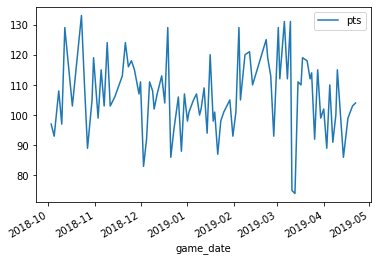

In [47]:
pistons_games.plot(x='game_date', y='pts')